In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from numba import njit
from torch.utils.data import Dataset, DataLoader

os.environ['KERAS_BACKEND'] = 'torch'
import bayesflow as bf

from bayesflow import diagnostics
from diffusion_model.helper_networks import ShallowSet

from diffusion_model import ScoreModel, SDE, train_score_model, count_parameters

In [2]:
torch_device = torch.device("cuda")

In [3]:
def draw_prior():
    p_samples = np.random.uniform(low=(-3.0, 0.1, 0.1, 0.1),
                                  high=(3.0, 3.0, 1.0, 0.9))
    return dict(drift=p_samples[0], boundary=p_samples[1], ndt=p_samples[2], beta=p_samples[3])

@njit
def diffusion_trial(drift, boundary, ndt, beta, dc=1.0, dt=1e-3):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    evidence = boundary * beta

    # Simulate a single DM path
    while (evidence > 0 and evidence < boundary):

        # DDM equation
        evidence += drift*dt + np.sqrt(dt) * dc * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt + ndt
    if evidence >= boundary:
        return rt, 1.
    return rt, 0.


def simulate_trials(drift, boundary, ndt, beta, n_trials=100):
    """Simulates a diffusion process for trials ."""
    choicert = np.empty((n_trials, 2))
    for i in range(n_trials):
        choicert[i] = diffusion_trial(drift, boundary, ndt, beta)
    return dict(obs=choicert)

# BayesFlow Baseline

In [4]:
class ShallowSetBF(bf.networks.SummaryNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.shallow_set = ShallowSet(dim_input=2, dim_output=8)

    def call(self, x, **kwargs):
        summary = self.shallow_set(x)
        return summary

In [5]:
simulator = bf.make_simulator([draw_prior, simulate_trials])

offline_set = simulator.sample(10000)
valid_set = simulator.sample(1000)

workflow = bf.BasicWorkflow(
    inference_network=bf.networks.CouplingFlow(
        coupling_kwargs=dict(subnet_kwargs=dict(dropout=0.1)),
    ),
    summary_network=ShallowSetBF(),
    inference_variables=["drift", "boundary", "ndt", "beta"],
    summary_variables=["obs"],
    simulator=simulator,
    checkpoint_filepath="checkpoint_test.ckpt",
)

#history = workflow.fit_online(epochs=50, batch_size=128, num_batches_per_epoch=10)
history = workflow.fit_offline(epochs=200, batch_size=128, data=offline_set, validation_data=valid_set)

workflow.plot_default_diagnostics(test_data=100, calibration_ecdf_kwargs={"difference": True});

# Score Matching

In [14]:
class Prior:
    def __init__(self):
        self.n_params_global = 4
        self.n_params_local = 0  # not a hierarchical model
        self.param_names = ['drift', 'boundary', 'ndt', 'beta']

        np.random.seed(0)
        sample_dict = simulator.sample(1000)
        thetas_global = np.array([sample_dict['drift'],
                                     sample_dict['boundary'],
                                     sample_dict['ndt'],
                                     sample_dict['beta']]).reshape(1000, 4)
        thetas_global = torch.tensor(thetas_global, dtype=torch.float32)

        self.norm_x_mean = torch.zeros(2, dtype=torch.float32) #torch.tensor(np.mean(sample_dict['obs'], axis=(0,1)), dtype=torch.float32)
        self.norm_x_std = torch.ones(2, dtype=torch.float32) #torch.tensor(np.std(sample_dict['obs'], axis=(0,1)), dtype=torch.float32)
        self.norm_prior_global_mean = torch.mean(thetas_global, dim=0)
        self.norm_prior_global_std = torch.std(thetas_global, dim=0)
        self.current_device = 'cpu'

    def normalize_theta(self, theta, global_params=True):
        self._move_to_device(theta.device)
        if global_params:
            return (theta - self.norm_prior_global_mean) / self.norm_prior_global_std
        raise ValueError('This is not a hierarchical model.')

    def denormalize_theta(self, theta, global_params=True):
        self._move_to_device(theta.device)
        if global_params:
            return theta * self.norm_prior_global_std + self.norm_prior_global_mean
        raise ValueError('This is not a hierarchical model.')

    def normalize_data(self, x):
        self._move_to_device(x.device)
        return (x - self.norm_x_mean) / self.norm_x_std

    def _move_to_device(self, device):
        if self.current_device != device:
            print(f"Moving prior to device: {device}")
            self.norm_prior_global_mean = self.norm_prior_global_mean.to(device)
            self.norm_prior_global_std = self.norm_prior_global_std.to(device)
            self.norm_x_mean = self.norm_x_mean.to(device)
            self.norm_x_std = self.norm_x_std.to(device)
            self.current_device = device
        return

class DiffusionProblem(Dataset):
    def __init__(self, n_data, prior, online_learning=False):
        # Create model and dataset
        self.prior = prior
        self.n_data = n_data
        self.online_learning = online_learning
        self._generate_data()

    def _generate_data(self):
        # Create model and dataset
        sample_dict = simulator.sample(self.n_data)
        thetas_global = np.array([sample_dict['drift'], sample_dict['boundary'],
                                  sample_dict['ndt'], sample_dict['beta']]).reshape(self.n_data, 4)
        self.thetas_global_unnormalized = torch.tensor(thetas_global, dtype=torch.float32)
        self.thetas_global = self.prior.normalize_theta(self.thetas_global_unnormalized, global_params=True)
        self.xs_unnormalized = torch.tensor(sample_dict['obs'], dtype=torch.float32)
        self.xs = self.prior.normalize_data(self.xs_unnormalized)

    def __len__(self):
        # this should return the size of the dataset
        return len(self.thetas_global)

    def __getitem__(self, idx):
        # this should return one sample from the dataset
        features = self.thetas_global[idx]
        target = self.xs[idx]
        noise = torch.randn_like(features)  # sample new noise each time
        return features, noise, target

    def on_epoch_end(self):  # for online learning
        # Regenerate data at the end of each epoch
        if self.online_learning:
            self._generate_data()

    def on_batch_end(self):
        pass

In [15]:
batch_size = 128
prior = Prior()

dataset = DiffusionProblem(
    n_data=10000,
    prior=prior,
    online_learning=False,
)
dataset_valid = DiffusionProblem(
    n_data=batch_size*10,
    prior=prior,
)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

Moving prior to device: cpu


In [9]:
for test in dataloader:
    features, noise, target = test
    print(features.shape, target.shape)
    break

torch.Size([128, 4]) torch.Size([128, 100, 2])


In [16]:
# Define diffusion model
current_sde = SDE(
    kernel_type=['variance_preserving', 'sub_variance_preserving'][0],
    noise_schedule=['linear', 'cosine', 'flow_matching'][0],
)

score_model = ScoreModel(
    input_dim_theta=prior.n_params_global,
    input_dim_x=8,
    summary_net=ShallowSet(dim_input=2, dim_output=8),
    input_dim_condition=0,
    hidden_dim=256,
    n_blocks=5,
    prediction_type=['score', 'e', 'x', 'v'][3],
    sde=current_sde,
    time_embed_dim=16,
    dropout_rate=0.1,
    use_spectral_norm=False,
    use_film=False,
    weighting_type=[None, 'likelihood_weighting', 'flow_matching', 'sigmoid'][0],
    name_prefix='diffusion_',
    max_number_of_obs=100,
    prior=prior
)
count_parameters(score_model)
print(score_model.name)

# make dir for plots
if not os.path.exists(f"plots/{score_model.name}"):
    os.makedirs(f"plots/{score_model.name}")

Kernel type: variance_preserving, noise schedule: linear
t_min: 0.0005980199202895164, t_max: 3.1622848510742188
alpha, sigma: (tensor(1.0000), tensor(0.0006)) (tensor(0.0067), tensor(1.0000))
+--------------------------------------+------------+
|               Modules                | Parameters |
+--------------------------------------+------------+
|            embed.0.scale             |     1      |
|            embed.1.weight            |    256     |
|             embed.1.bias             |     16     |
|       summary_net.enc.0.weight       |    256     |
|        summary_net.enc.0.bias        |    128     |
|       summary_net.enc.2.weight       |   16384    |
|        summary_net.enc.2.bias        |    128     |
|       summary_net.enc.4.weight       |   16384    |
|        summary_net.enc.4.bias        |    128     |
|       summary_net.enc.6.weight       |   16384    |
|        summary_net.enc.6.bias        |    128     |
|       summary_net.dec.0.weight       |   16384   

Training v-model for 100 epochs with learning rate 0.001 and None weighting.
Model has 4 parameters and is uses compositional conditioning with 100 observations.


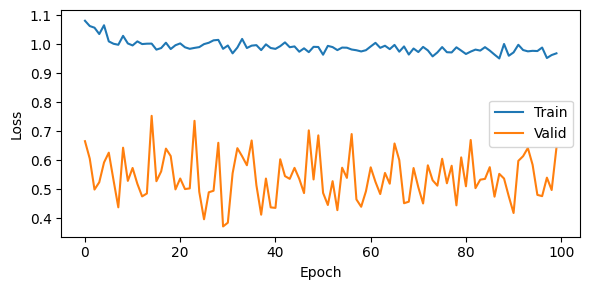

In [17]:
# train model
loss_history = train_score_model(score_model, dataloader, dataloader_valid=dataloader_valid,
                                 epochs=100, device=torch_device, cosine_annealing=False, lr=1e-3)
score_model.eval()
torch.save(score_model.state_dict(), f"models/{score_model.name}.pt")

# plot loss history
plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(loss_history[:, 0], label='Train')
plt.plot(loss_history[:, 1], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'plots/{score_model.name}/loss_training.png')

## Sampling

In [ ]:
from diffusion_model import langevin_sampling, adaptive_sampling

In [ ]:
n_post_samples = 100

dataset_test = DiffusionProblem(
    n_data=100,
    prior=prior,
)

valid_data = dataset_test.xs_unnormalized
valid_prior = dataset_test.thetas_global_unnormalized
param_names = prior.param_names

In [ ]:
# posterior_global_samples_valid = langevin_sampling(score_model, valid_data, n_post_samples=n_post_samples,
#                                                    #mini_batch_arg=mini_batch_arg,
#                                                    diffusion_steps=300, langevin_steps=5, step_size_factor=0.05,
#                                                    device=torch_device, verbose=True)

posterior_global_samples_valid = adaptive_sampling(score_model, valid_data, n_post_samples=n_post_samples,
                                                   #mini_batch_arg=mini_batch_arg,
                                                   run_sampling_in_parallel=False,
                                                   device=torch_device, verbose=False)

In [ ]:
diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior), variable_names=param_names)
diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior),
                             difference=True, variable_names=param_names);